In [25]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import dask
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import fsspec
import requests
import aiohttp
import nc_time_axis
import cftime
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [27]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2' & experiment_id =='abrupt-4xCO2'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[-1]), consolidated=True)
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])

In [28]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_tas_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR'")

# df_ta_ncar.experiment_id.unique()
df_tas_ncar

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
53470,CMIP,NCAR,CESM2,amip,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/amip/r1i1p1f1...,NaN,20190218
55166,CMIP,NCAR,CESM2,amip,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/amip/r3i1p1f1...,NaN,20190220
55264,CMIP,NCAR,CESM2,amip,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/amip/r2i1p1f1...,NaN,20190220
59875,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
61655,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
61862,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
62691,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
63131,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
63266,CMIP,NCAR,CESM2,historical,r6i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
64615,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...,NaN,20190311


In [29]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_tas_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'abrupt-4xCO2'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_tas_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_tas_his = xr.open_zarr(mapper_his, consolidated=True)
ds_tas_his

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/tas/gn/v20190927/


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 11988)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 0001-01-15 12:00:00 ... 0999-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(11988, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(823, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          hybrid
    branch_time_in_child:   -182500.0
    branch_time_in_parent:  182865.0
    case_id:                46
    ...                     ...
    tracking_id:            hdl:21.14100/81280768-5338-4e76-a8cc-478d15b08664...
    variable_id:            tas
    variant_info:           CMIP6 CESM2 abrupt4xCO2 experiment with CAM6, int...
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/81280768-5338-4e76-a8cc-478d15b08664...
    version_id:             v20190927

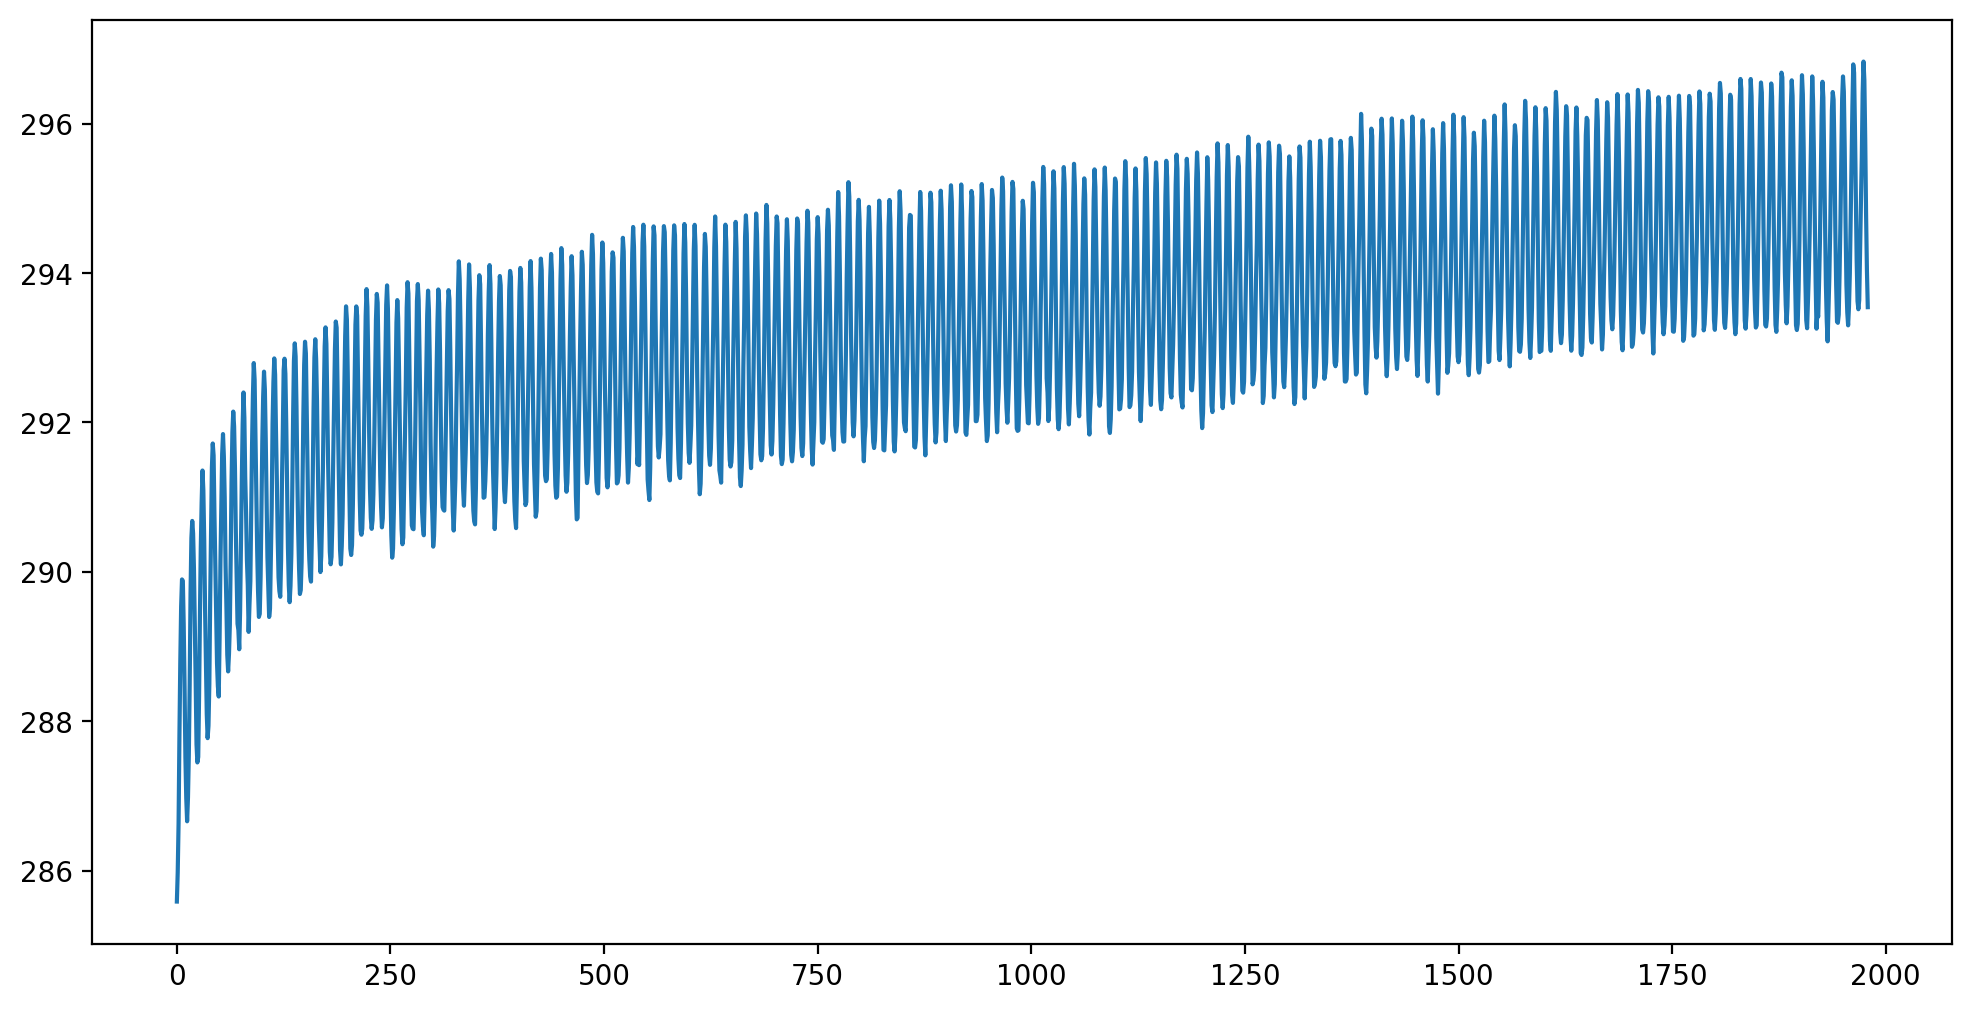

In [30]:
date_threshold = cftime.DatetimeNoLeap(166, 1, 1)
ds_tas_his_plt = ds_tas_his.where(ds_tas_his.time < date_threshold, drop=True)
tas_timeseries_his = (ds_tas_his_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
array_tas_ts = np.array(tas_timeseries_his)
plt.plot(array_tas_ts)
plt.show()
# year_tas_ts = np.mean(array_tas_ts.reshape(len(array_tas_ts) // 12, 12), axis=1)
# plt.plot(year_tas_ts)
# plt.show()

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/rtmt/gn/v20190927/


<xarray.Dataset>
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 0001-01-15 12:00:00 ... 0165-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    rtmt       (time, lat, lon) float32 dask.array<chunksize=(319, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          hybrid
    branch_time_in_child:   -182500.0
    branch_time_in_parent:  182865.0
    case_id:                46
    ...                     ...
    tracking_id:            hdl:21.14100/29405854-5f44-4c84-bdb1-8932ccfaaea0...
    variable_id:            rtmt
    variant_info:           CMIP6 CESM2 abrupt4xCO2 experiment with CAM6, int...
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/29405854-5f44-4c84-bdb1-8932ccfaaea0...
    version_id:             v20190927

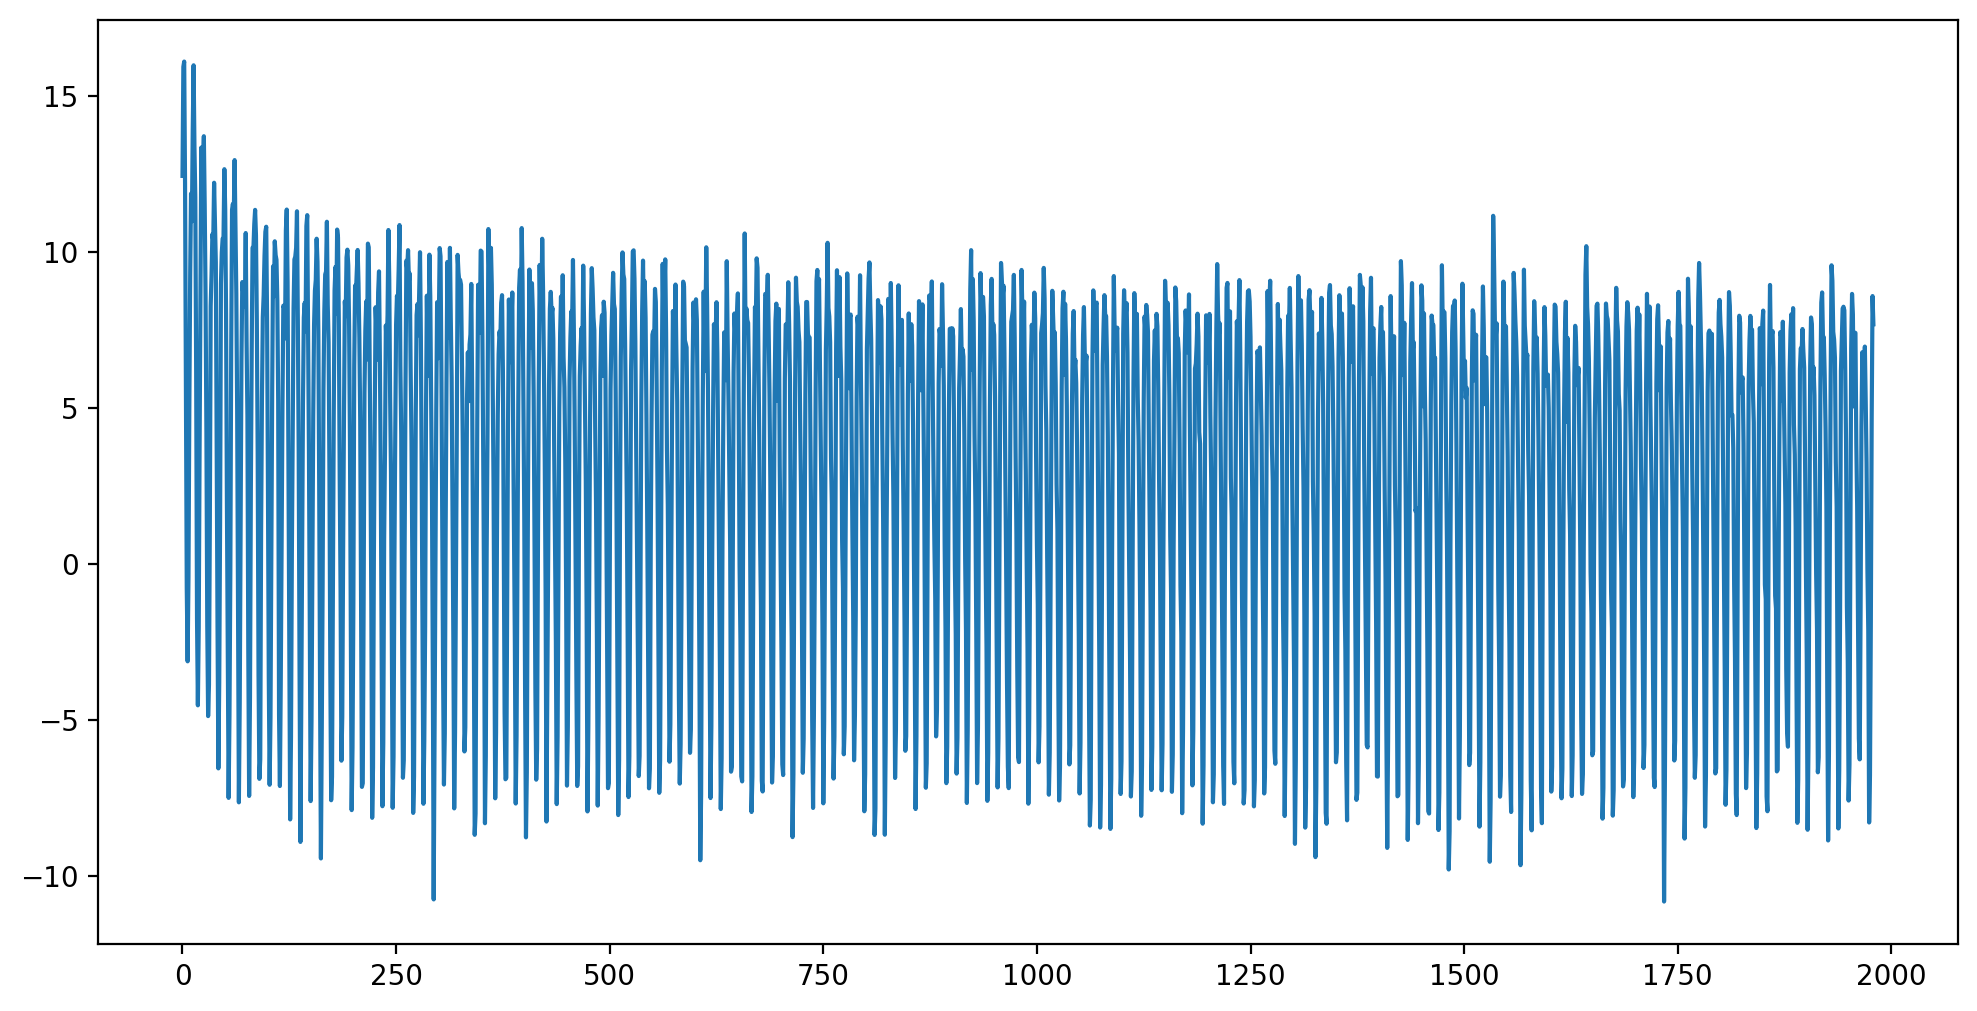

In [31]:
df_radflux_ncar_1pct = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'rtmt' & institution_id == 'NCAR' & experiment_id == 'abrupt-4xCO2'")

zstore_rtmt = df_radflux_ncar_1pct.zstore.values[-1]
print(zstore_rtmt)

# create a mutable-mapping-style interface to the store
mapper_rtmt = fsspec.get_mapper(zstore_rtmt)

# open it using xarray and zarr
ds_radflux_1pct = xr.open_zarr(mapper_rtmt, consolidated=True)

# time threshold for security
ds_radflux_1pct_plt = ds_radflux_1pct.where(ds_radflux_1pct.time < date_threshold, drop=True)
display(ds_radflux_1pct_plt)

radflux_timeseries_1pct = (ds_radflux_1pct_plt.rtmt * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
array_radflux_ts = np.array(radflux_timeseries_1pct)
plt.plot(array_radflux_ts)
plt.show()
# year_radflux_ts = np.mean(array_radflux_ts.reshape(len(array_radflux_ts) // 12, 12), axis=1)
# plt.plot(year_radflux_ts)
# plt.show()

$N = F - \alpha \Delta T$

### By selecting different reference temperature, F takes different value, but climate feedback parameter a remains the same

Climate Feedback Parameter (a): 2.470 W/m²/K
Radiative Forcing (F): 35.668 W/m²


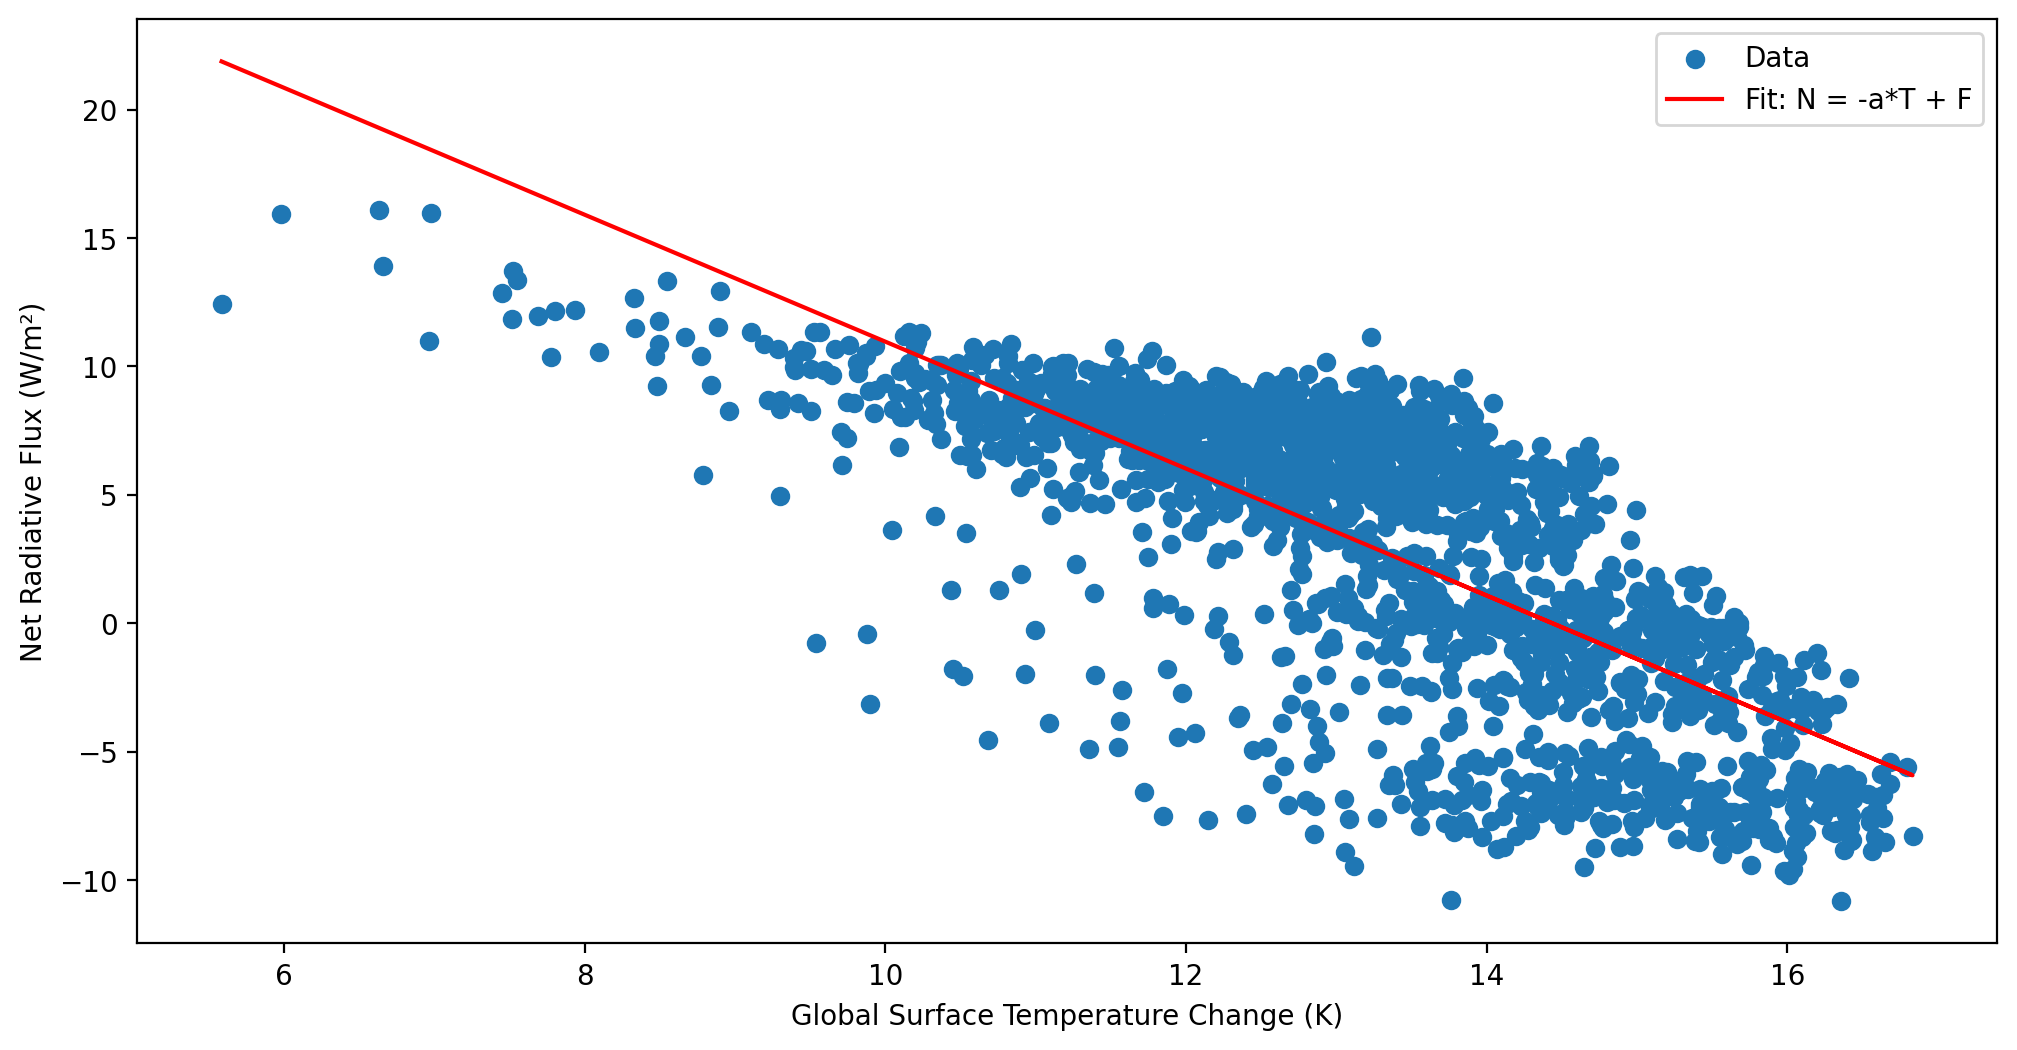

In [38]:

delta_T= array_tas_ts - 280
N = array_radflux_ts

X = delta_T.reshape(-1, 1)
y = N

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Extract results
a = -model.coef_[0]  # Slope is negative feedback parameter
F = model.intercept_  # Intercept is radiative forcing

print(f"Climate Feedback Parameter (a): {a:.3f} W/m²/K")
print(f"Radiative Forcing (F): {F:.3f} W/m²")

# Optional: Plot
plt.scatter(delta_T, N, label="Data")
plt.plot(delta_T, model.predict(X), color='red', label="Fit: N = -a*T + F")
plt.xlabel("Global Surface Temperature Change (K)")
plt.ylabel("Net Radiative Flux (W/m²)")
plt.legend()
plt.show()

$N = \epsilon \ln{\frac{CO2}{280}} - \alpha \Delta T$

In [33]:
df_co2ms_ncar_4x = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'co2mass' & institution_id == 'NCAR' & experiment_id == 'abrupt-4xCO2'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_co2ms_ncar_4x.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_co2ms_his = xr.open_zarr(mapper_his, consolidated=True)
date_threshold = cftime.DatetimeNoLeap(166, 1, 1)
ds_co2ms_his_plt = ds_co2ms_his.where(ds_co2ms_his.time < date_threshold, drop=True)
ds_co2ms_his_plt

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/co2mass/gn/v20190927/


<xarray.Dataset>
Dimensions:    (time: 1980, nbnd: 2)
Coordinates:
  * time       (time) object 0001-01-15 12:00:00 ... 0165-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    co2mass    (time) float32 dask.array<chunksize=(1980,), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          hybrid
    branch_time_in_child:   -182500.0
    branch_time_in_parent:  182865.0
    case_id:                46
    ...                     ...
    tracking_id:            hdl:21.14100/f5ebc3dd-ccbd-442e-bfc9-11af489c2fe4...
    variable_id:            co2mass
    variant_info:           CMIP6 CESM2 abrupt4xCO2 experiment with CAM6, int...
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/f5ebc3dd-ccbd-442e-bfc9-11af489c2fe4...
    version_id:             v20190927

In [34]:
array_co2ms_ts = np.array(ds_co2ms_his_plt.co2mass)
# init_1xco2 = 2226581800000000.0
conc_after = 4 * 280 / (1 + 3 * 1e-6)
month_co2_ts = np.full(len(array_co2ms_ts), conc_after)

Radiative Forcing Efficiency (epsilon): 0.040 W/m²
Climate Feedback Parameter (alpha): 2.470 W/m²/K
Baseline Radiative Flux (Intercept): 21.816 W/m²


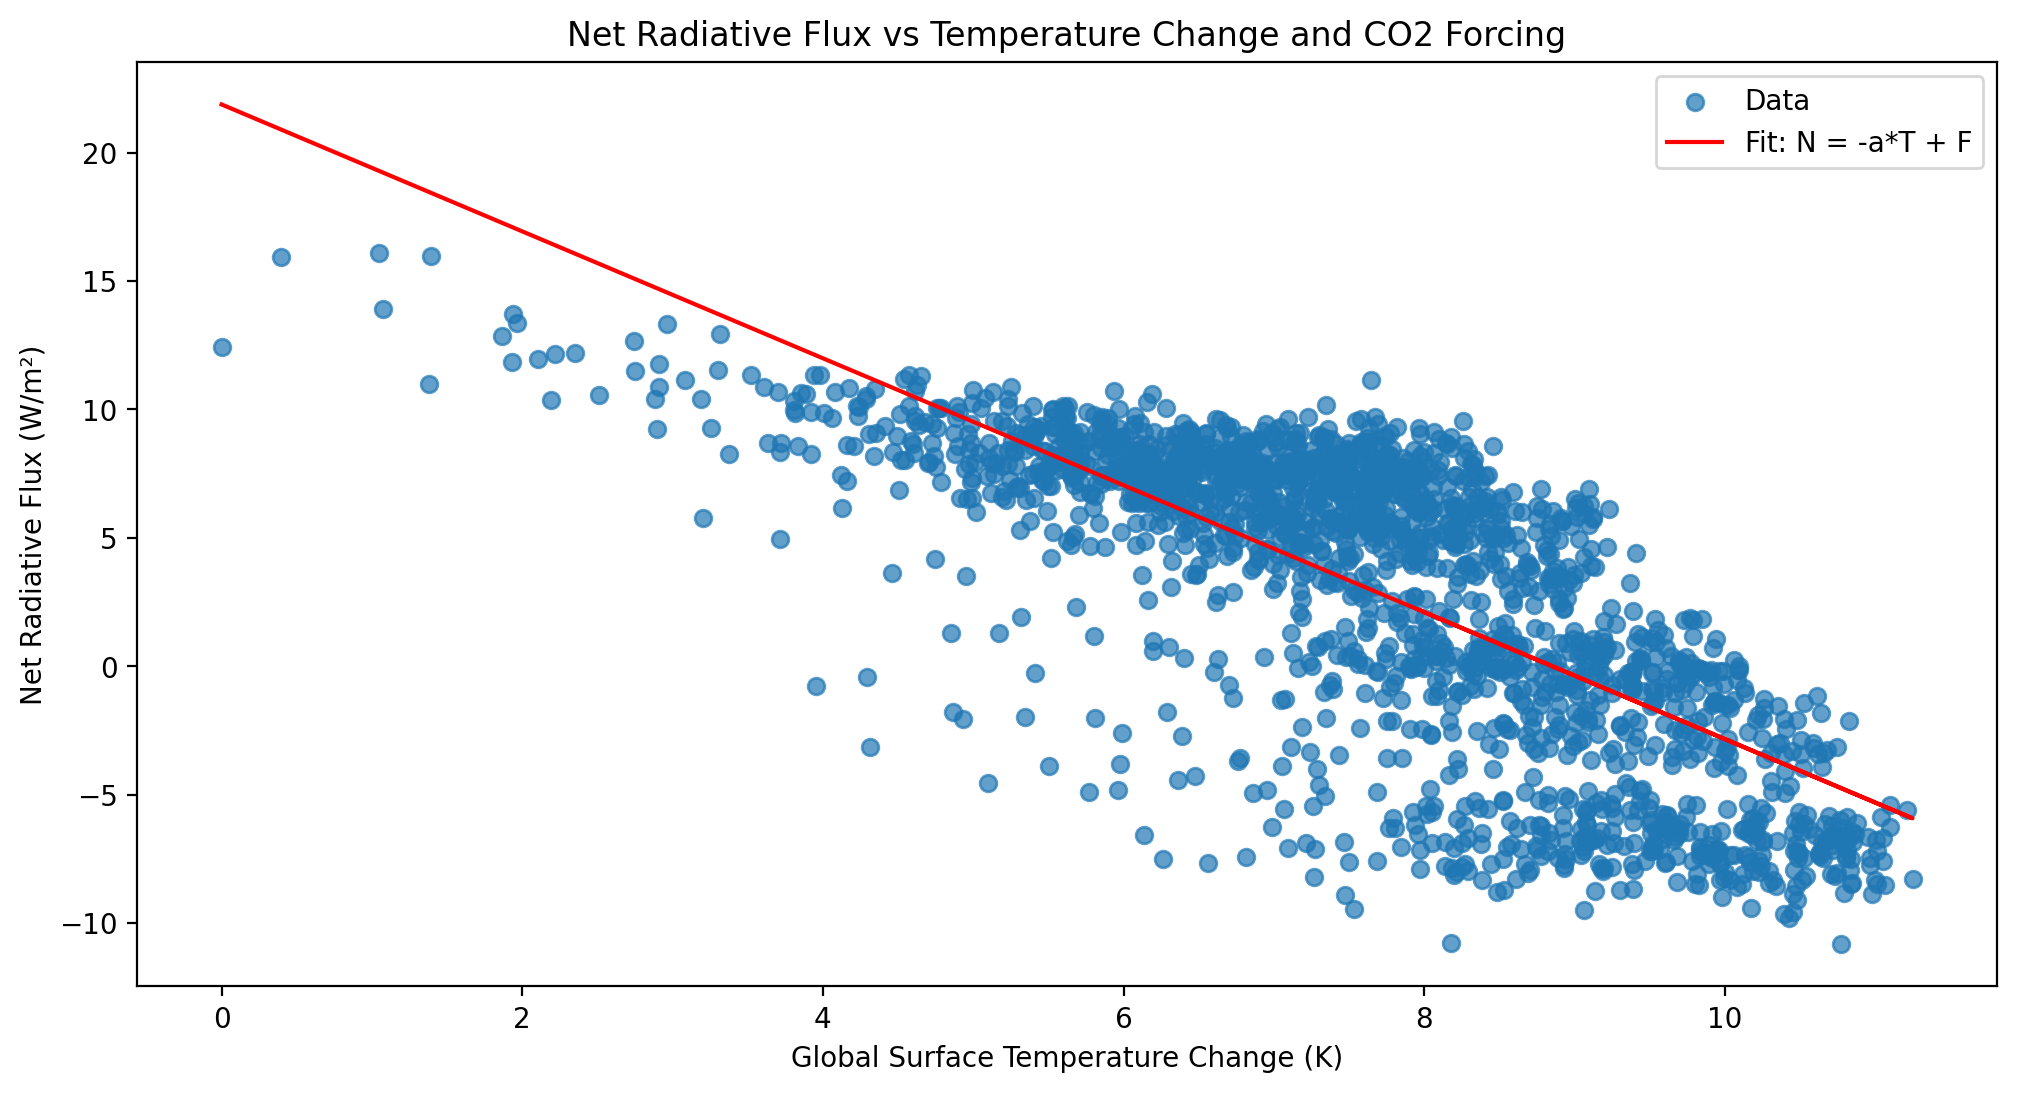

In [35]:
# Sample data (replace with your time series)
CO2 = month_co2_ts         # Atmospheric CO2 concentrations (ppm)
delta_T= array_tas_ts - array_tas_ts[0]
N = array_radflux_ts         # Net downward radiative flux (W/m²)

# Calculate the logarithmic forcing term
log_forcing = np.log(CO2 / 280)  # Reference CO2 concentration = 280 ppm

# Prepare independent variables for multiple linear regression
X = np.column_stack((log_forcing, delta_T))  # Combine \ln(CO2/280) and \Delta T

# Perform multiple linear regression
model = LinearRegression()
model.fit(X, N)

# Extract coefficients
epsilon = model.coef_[0]  # Coefficient for \ln(CO2 / 280)
alpha = -model.coef_[1]   # Negative of the slope for \Delta T (feedback parameter)
F_intercept = model.intercept_  # Intercept (baseline radiative flux if both terms are zero)

# Print results
print(f"Radiative Forcing Efficiency (epsilon): {epsilon:.3f} W/m²")
print(f"Climate Feedback Parameter (alpha): {alpha:.3f} W/m²/K")
print(f"Baseline Radiative Flux (Intercept): {F_intercept:.3f} W/m²")

# Optional: Plot results
plt.scatter(delta_T, N, label="Data", alpha=0.7)
plt.plot(delta_T, model.predict(X), color='red', label="Fit: N = -a*T + F")
plt.xlabel("Global Surface Temperature Change (K)")
plt.ylabel("Net Radiative Flux (W/m²)")
plt.title("Net Radiative Flux vs Temperature Change and CO2 Forcing")
plt.legend()
plt.show()

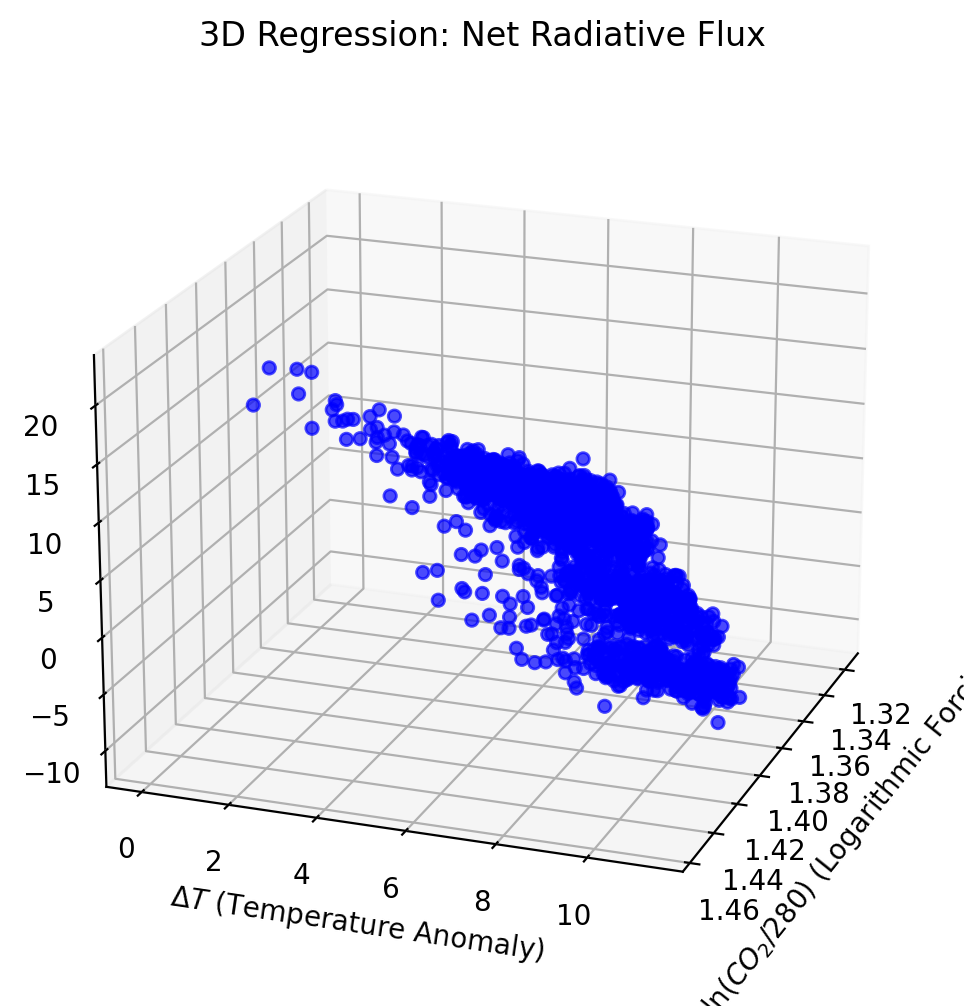

In [36]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(log_forcing, delta_T, N, label="Data Points", color='blue', alpha=0.7)

# Generate a regression surface
log_forcing_range = np.linspace(min(log_forcing), max(log_forcing), 50)
delta_T_range = np.linspace(min(delta_T), max(delta_T), 50)
log_forcing_grid, delta_T_grid = np.meshgrid(log_forcing_range, delta_T_range)
N_predicted = (
    model.intercept_
    + model.coef_[0] * log_forcing_grid
    + model.coef_[1] * delta_T_grid
)

# Plot the regression surface
ax.plot_surface(
    log_forcing_grid, delta_T_grid, N_predicted, color='red', alpha=0.5, label="Regression Surface"
)

# Label the axes
ax.set_xlabel(r"$\ln(CO_2 / 280)$ (Logarithmic Forcing)")
ax.set_ylabel(r"$\Delta T$ (Temperature Anomaly)")
ax.set_zlabel(r"$N$ (Net Radiative Flux)")
ax.set_title("3D Regression: Net Radiative Flux")

ax.view_init(elev=20, azim=20)
# Show the plot
plt.show()